# **Porter Delivery Time Estimation**

## Importing libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
#for reading and handling the data
import pandas as pd
import numpy as np
import os

#for visualizinng and analyzing it
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#ann training
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError

from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Loading the data from kaggle

In [ ]:
df=pd.read_csv('/content/porter_data.csv')

## Printing the head and information of the data to get an understanding of it

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_primary_category                        175777 non-null  int64  
 4   order_protocol                                175777 non-null  float64
 5   total_items                                   175777 non-null  int64  
 6   subtotal                                      175777 non-null  int64  
 7   num_distinct_items                            175777 non-null  int64  
 8   min_item_price                                175777 non-null  int64  
 9   max_item_price                                17

## Data preprocessing

In [ ]:
df['created_at']=pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175777 non-null  float64       
 1   created_at                                    175777 non-null  datetime64[ns]
 2   actual_delivery_time                          175777 non-null  datetime64[ns]
 3   store_primary_category                        175777 non-null  int64         
 4   order_protocol                                175777 non-null  float64       
 5   total_items                                   175777 non-null  int64         
 6   subtotal                                      175777 non-null  int64         
 7   num_distinct_items                            175777 non-null  int64         
 8   min_item_price                                175777 n

In [ ]:
df['time_taken']=df['actual_delivery_time'] - df['created_at']

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype          
---  ------                                        --------------   -----          
 0   market_id                                     175777 non-null  float64        
 1   created_at                                    175777 non-null  datetime64[ns] 
 2   actual_delivery_time                          175777 non-null  datetime64[ns] 
 3   store_primary_category                        175777 non-null  int64          
 4   order_protocol                                175777 non-null  float64        
 5   total_items                                   175777 non-null  int64          
 6   subtotal                                      175777 non-null  int64          
 7   num_distinct_items                            175777 non-null  int64          
 8   min_item_price                              

In [ ]:
df['time_taken_mins']=pd.to_timedelta(df['time_taken'])/pd.Timedelta('60s')

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken,time_taken_mins
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00,47.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00,44.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00,55.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00,59.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00,46.0


In [ ]:
df['hour']=df['created_at'].dt.hour
df['day']=df['created_at'].dt.dayofweek

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,time_taken,time_taken_mins,hour,day
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,0 days 00:47:00,47.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,0 days 00:44:00,44.0,21,1
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0 days 00:55:00,55.0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,0 days 00:59:00,59.0,3,3
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,0 days 00:46:00,46.0,2,1


In [ ]:
df.drop(['time_taken','created_at','actual_delivery_time'],axis=1,inplace=True)

Checking null values in the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   store_primary_category                        175777 non-null  int64  
 2   order_protocol                                175777 non-null  float64
 3   total_items                                   175777 non-null  int64  
 4   subtotal                                      175777 non-null  int64  
 5   num_distinct_items                            175777 non-null  int64  
 6   min_item_price                                175777 non-null  int64  
 7   max_item_price                                175777 non-null  int64  
 8   total_onshift_dashers                         175777 non-null  float64
 9   total_busy_dashers                            17

In [ ]:
df.isna().sum()

,0
market_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0
max_item_price,0
total_onshift_dashers,0
total_busy_dashers,0


dropping null values from the data(if present)

Plotting correlation to get an idea of the data

<Axes: >

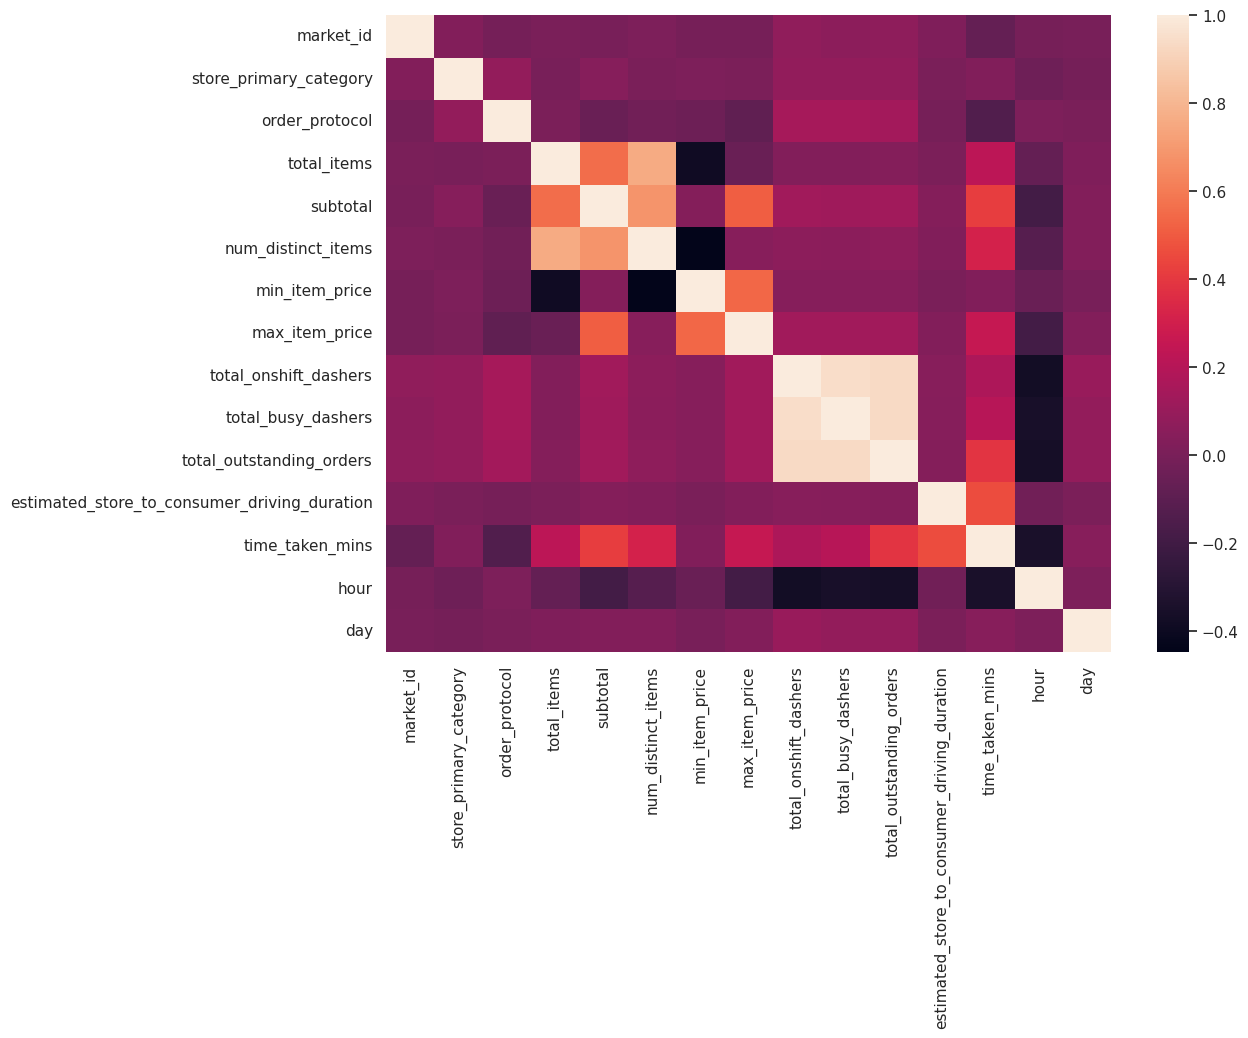

In [ ]:
sns.heatmap(df.corr())

we have one categorical column which we will change to integer for model

In [ ]:
df['store_primary_category']=df['store_primary_category'].astype('category').cat.codes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   store_primary_category                        175777 non-null  int8   
 2   order_protocol                                175777 non-null  float64
 3   total_items                                   175777 non-null  int64  
 4   subtotal                                      175777 non-null  int64  
 5   num_distinct_items                            175777 non-null  int64  
 6   min_item_price                                175777 non-null  int64  
 7   max_item_price                                175777 non-null  int64  
 8   total_onshift_dashers                         175777 non-null  float64
 9   total_busy_dashers                            17

## Data Visualization and Cleaning

<Axes: xlabel='time_taken_mins', ylabel='subtotal'>

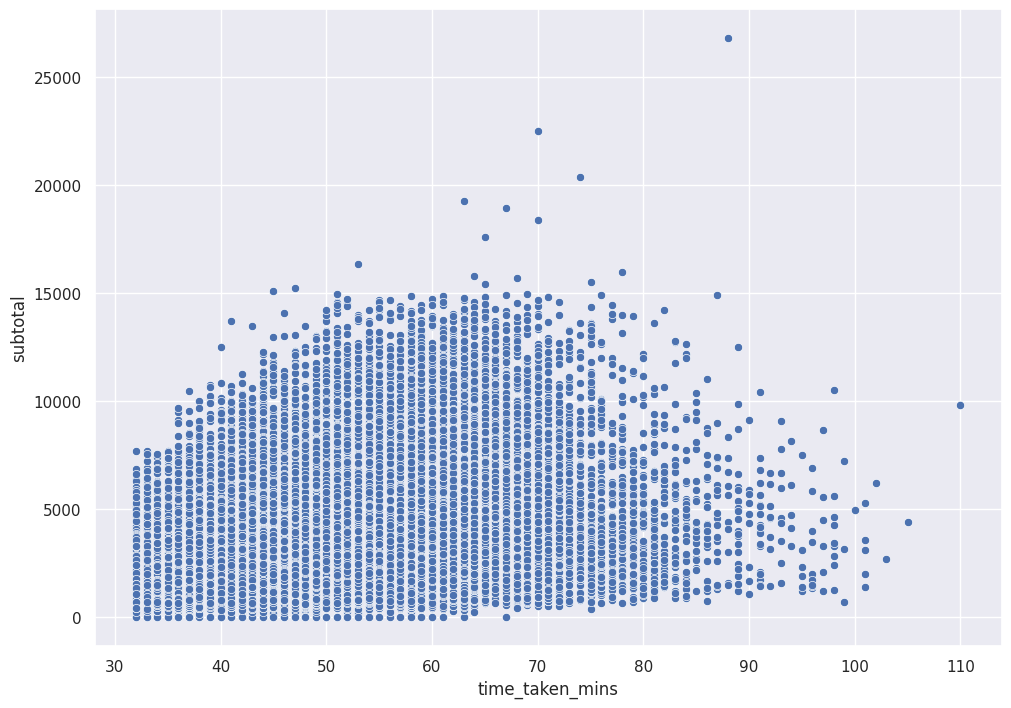

In [ ]:
sns.scatterplot(x='time_taken_mins',y='subtotal',data=df)

<Axes: xlabel='total_items', ylabel='subtotal'>

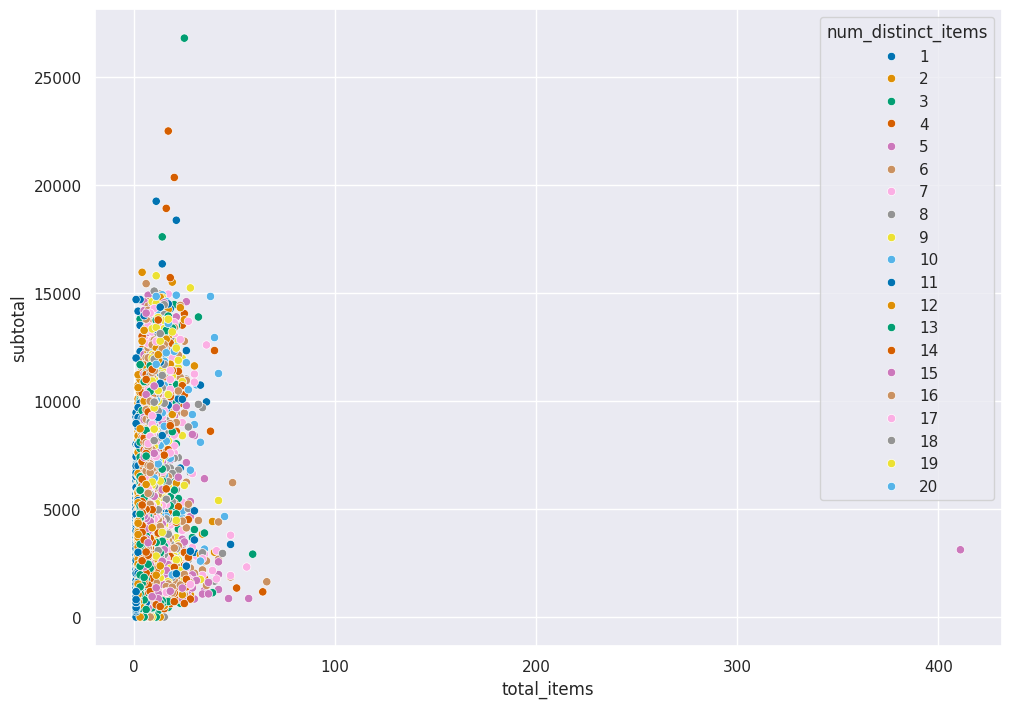

In [ ]:
sns.scatterplot(x='total_items',y='subtotal',hue='num_distinct_items',palette='colorblind',data=df)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
model1=LocalOutlierFactor()
#model1.fit(df)
df['lof_anomaly_score']=model1.fit_predict(df)

In [ ]:
print("number of outliers : ",(len(df.loc[(df['lof_anomaly_score'] == -1)])))
df=df.loc[(df['lof_anomaly_score'] == 1)]

number of outliers :  831


In [ ]:
df.drop(['lof_anomaly_score'],axis=1,inplace=True)

<ipython-input-27-a629ff9cb1da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['lof_anomaly_score'],axis=1,inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174946 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     174946 non-null  float64
 1   store_primary_category                        174946 non-null  int8   
 2   order_protocol                                174946 non-null  float64
 3   total_items                                   174946 non-null  int64  
 4   subtotal                                      174946 non-null  int64  
 5   num_distinct_items                            174946 non-null  int64  
 6   min_item_price                                174946 non-null  int64  
 7   max_item_price                                174946 non-null  int64  
 8   total_onshift_dashers                         174946 non-null  float64
 9   total_busy_dashers                            174946 

<Axes: xlabel='time_taken_mins', ylabel='subtotal'>

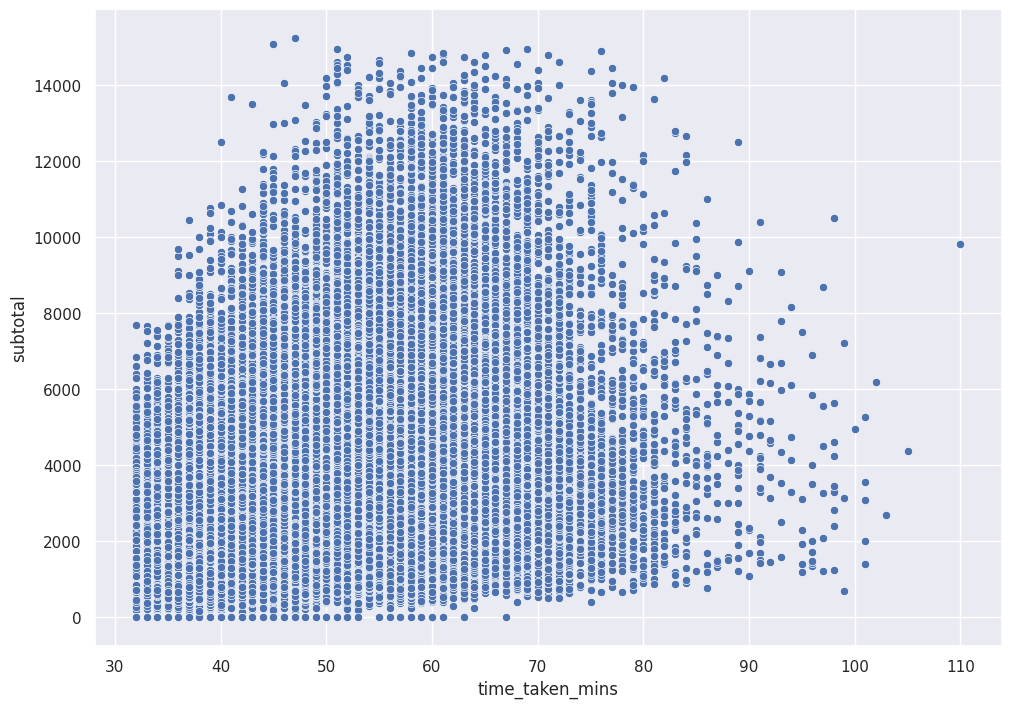

In [ ]:
sns.scatterplot(x='time_taken_mins',y='subtotal',data=df)

We can see that after removing outliers our data is looking better

In [ ]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'time_taken_mins',
       'hour', 'day'],
      dtype='object')

<Axes: xlabel='day', ylabel='count'>

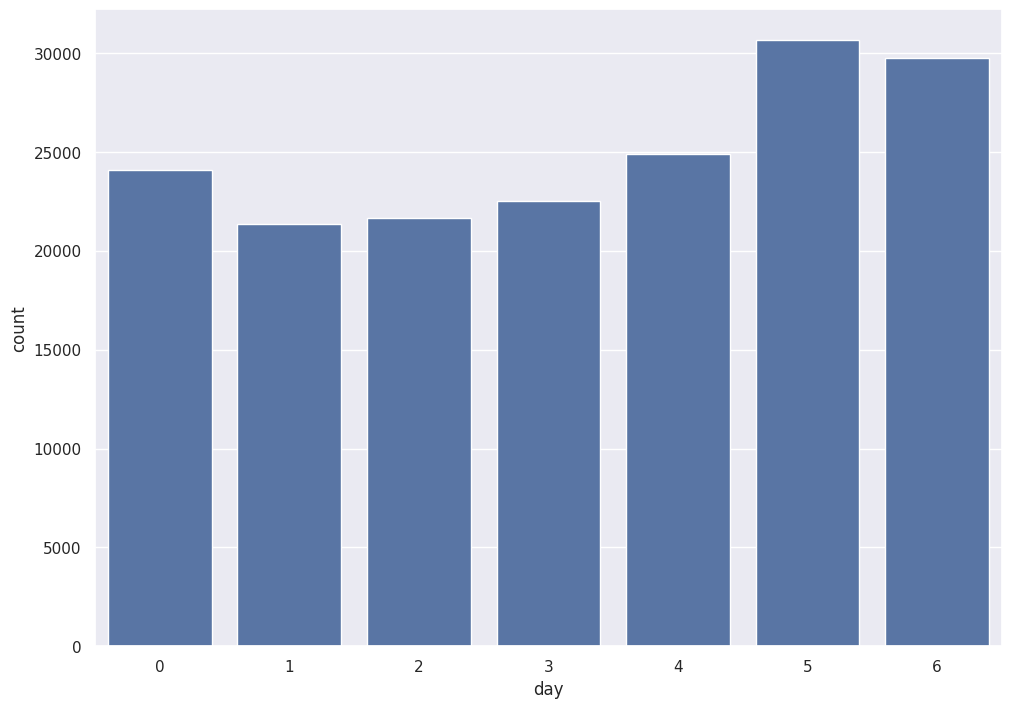

In [ ]:
sns.countplot(x=df.day)

a little more orders on the weekends

<Axes: xlabel='hour', ylabel='count'>

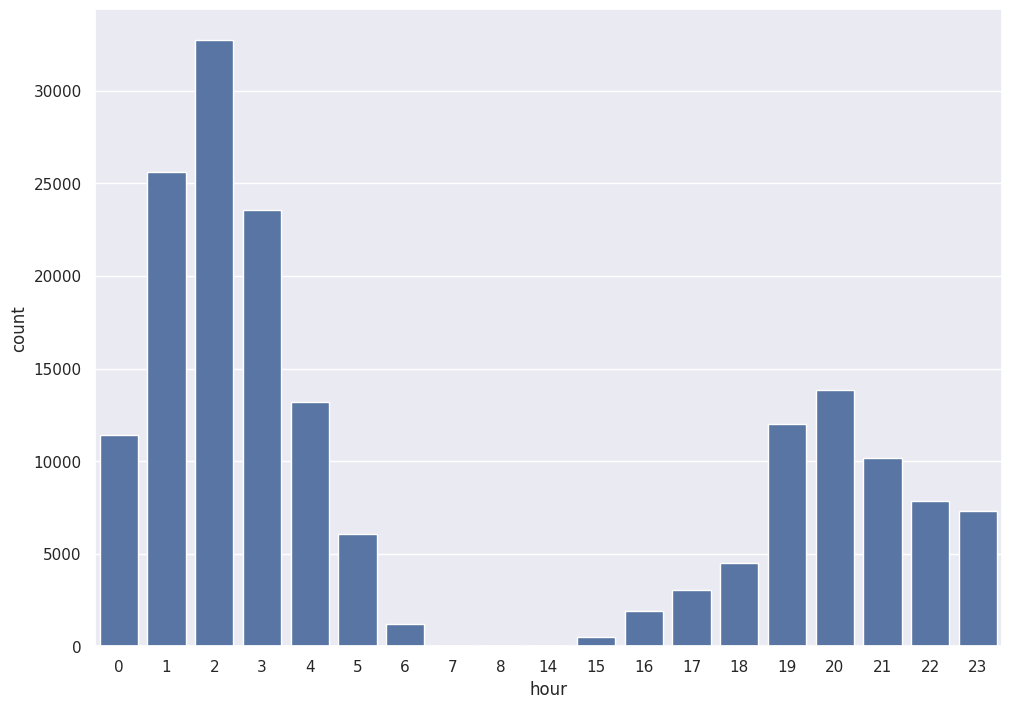

In [ ]:
sns.countplot(x=df.hour)

<Axes: xlabel='hour', ylabel='time_taken_mins'>

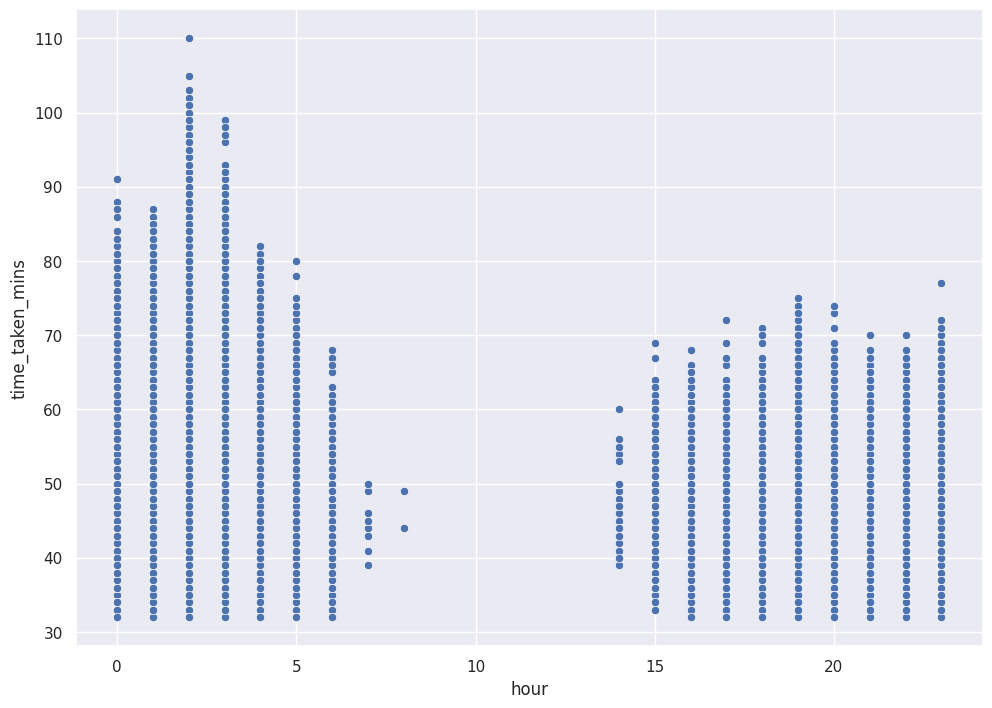

In [ ]:
sns.scatterplot(x='hour',y='time_taken_mins',data=df)

## Data Splitting and Modelling

In [ ]:
y=df['time_taken_mins']
x=df.drop(['time_taken_mins'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,hour,day
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,22,4
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,21,1
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,3,3
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,2,1


## **Random Forest**

In [ ]:
regressor=RandomForestRegressor()
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
prediction=regressor.predict(X_test)
mse=mean_squared_error(y_test,prediction)
rmse=mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
mae=mean_absolute_error(y_test,prediction)
print("mase : ",mae)

mse :  3.2246571191769084
rmse :  1.7957330311538262
mase :  1.283623892540726


In [ ]:
r2_score(y_test,prediction)

0.9625215915106187

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape=np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
print("mape : ",MAPE(y_test,prediction))

mape :  2.7652434831268455


Text(0.5, 0, 'Random Forest Feature Importance')

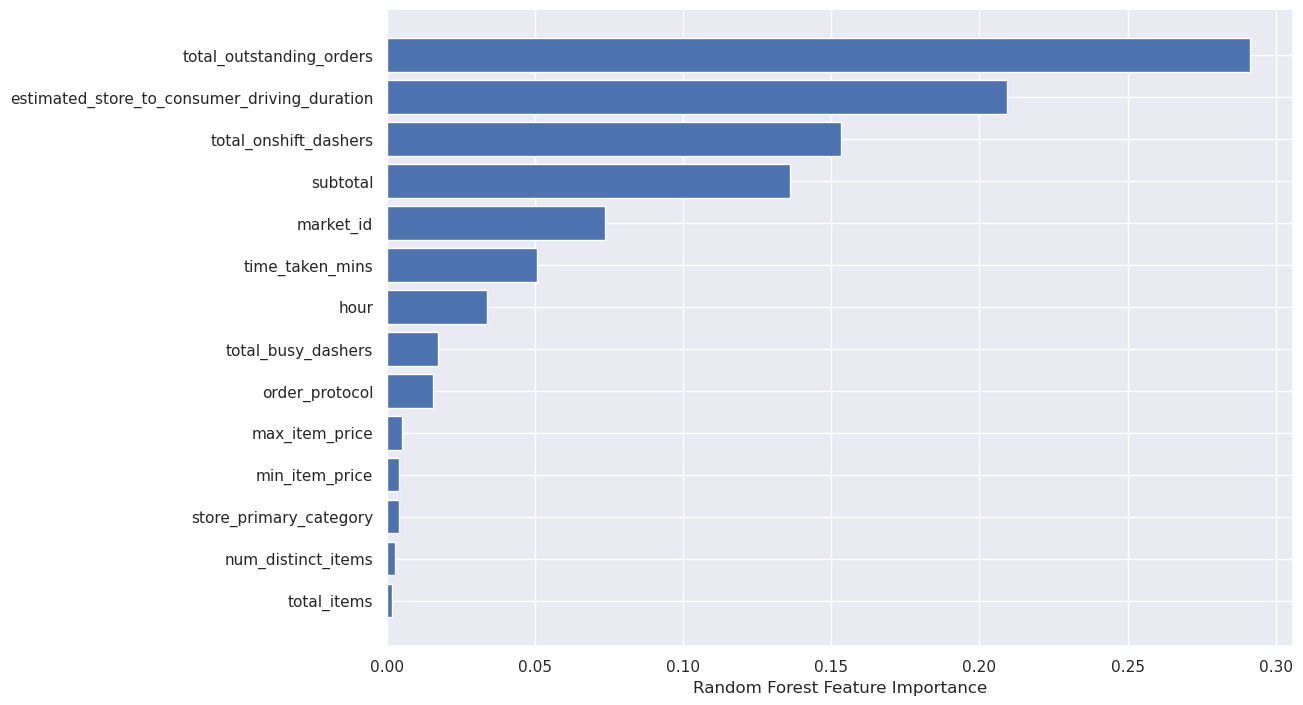

In [ ]:
sorted_idx=regressor.feature_importances_.argsort()
plt.barh(df.columns[sorted_idx],regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## **Neural Networks**

Scalling the data to feed before neural network

In [ ]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
x_scaled=scaler.fit_transform(x)
X_train,X_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

In [ ]:
model=Sequential()
model.add(Dense(14,kernel_initializer='normal',activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
from tensorflow.keras.optimizers import Adam
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])
history=model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 325.0128 - mae: 12.1741 - mse: 325.0128 - val_loss: 5.9680 - val_mae: 1.7826 - val_mse: 5.9680
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 4.6148 - mae: 1.5679 - mse: 4.6148 - val_loss: 2.8865 - val_mae: 1.2347 - val_mse: 2.8865
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 2.6407 - mae: 1.2134 - mse: 2.6407 - val_loss: 3.4450 - val_mae: 1.5465 - val_mse: 3.4450
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 2.0042 - mae: 1.0908 - mse: 2.0042 - val_loss: 6.1359 - val_mae: 2.2703 - val_mse: 6.1359
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 1.5531 - mae: 0.9583 - mse: 1.5531 - val_loss: 0.6342 - val_mae: 0.6247 - val_mse: 0.6342
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 1.5289 - mae: 0.9719 - mse: 1.5289 - val_loss: 1.0595 - val_mae: 0.8614 - val_mse: 1.0595
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - loss: 1.0348 - mae: 0.7912

we plot train and validation loss throughout training

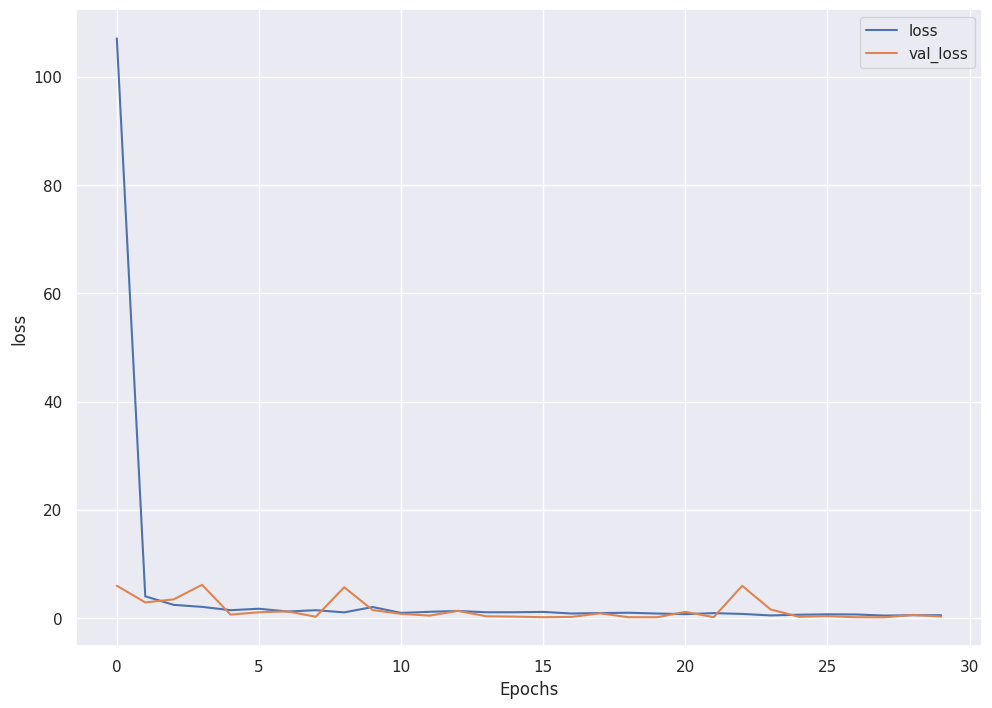

In [ ]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()
#plot the history
plot_history(history,'loss')

val loss is below training loss so our model is not overfitting

In [ ]:
z= model.predict(X_test)

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [ ]:
r2_score(y_test, z)

0.9968542686597435

In [ ]:
mse = mean_squared_error(y_test, z)
rmse = mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
print("errors for neural net")
mae = mean_absolute_error(y_test, z)
print("mae : ",mae)

mse :  0.2706599711738081
rmse :  0.5202499122285443
errors for neural net
mae :  0.4301021189442973


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, z)

0.009434215653366511